## Regression of a function with a neural network in 1D


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# Generate synthetic data
x = torch.linspace(0, 5, 100)
x.requires_grad = True
x = x.unsqueeze(-1)

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        # self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        # x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the loss function
MSELoss = lambda x, y: torch.mean(torch.square(x - y))

def train_net(net, x, get_dydx, get_y_lhs, get_y_rhs, criterion, verbose = False):
    optimizer = optim.LBFGS(net.parameters(), lr=0.01)
    for i in range(100):
        def closure():
            optimizer.zero_grad()
            # outputs = net(x)
            y = get_y_rhs(x, net)
            dydx = get_dydx(x, net, get_y_lhs)
            loss = criterion(y, dydx) 
            loss.backward()
            return loss

        loss=optimizer.step(closure)

        if(verbose):
            if(i%10==0):
                print(i," ",loss.item())

    # Print the final loss
      
def plot_net(net, x, get_y, ax = None, analytical = None):
    # Plot the results
    with torch.no_grad():
        outputs = get_y(x, net)

    if ax is None:
        fig, plot_ax = plt.subplots()
    else:
        plot_ax = ax

    plot_ax.plot(x.detach().numpy(),  outputs.detach().numpy(), label='Neural Network Prediction', color='red')
    if analytical is not None:
        plot_ax.plot(x.detach().numpy(), analytical(x.detach().numpy()), '--',label='Analytical Solution', color='blue')
    plot_ax.set_xlabel('x')
    plot_ax.set_ylabel('y')
    plot_ax.legend()

    if ax is None:
        plt.show()

### Exercise 2:
Modify the code to solve the differential equation
$$
\frac{dy}{dx} = -y(x);\; y(0) = 1
$$
using
 a) finite difference method to calculate derivatives.

Add boundary conditions as another loss function.


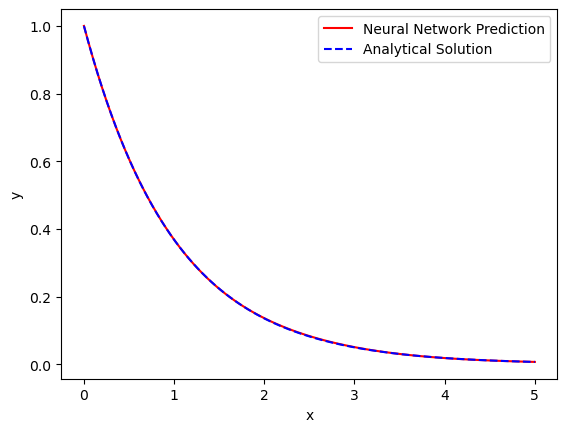

In [4]:
analytical = lambda x: np.exp(-x)


def get_dydx(x, net, getout):
    h = 0.001
    dydx = (getout(x+h, net) - getout(x-h, net)) /(2*h)
    return -dydx


def get_y(x, net):
    return net(x)


net = Net()

MSELoss_w_bound = lambda x, y: MSELoss(x, y) + torch.square(net(torch.tensor([0.])) - torch.tensor( [1.]))/10.


train_net(net, x, get_dydx, get_y, get_y, MSELoss_w_bound)

plot_net(net, x, get_y, analytical = analytical)

We have plotted the solution along with the analytical solution ($e^{-x}$). As can be see, the PINN work flawlessly out of the gate!


 b) automatic differentiation to calculate derivatives. 

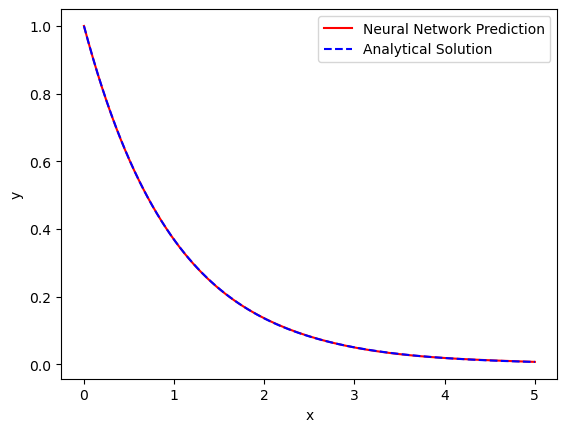

In [5]:
def get_dydx_auto(x, net, get_y_lhs):
    y = get_y_lhs(x, net)
    dydx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    
    return -dydx

net = Net()

train_net(net, x, get_dydx_auto, get_y, get_y, MSELoss_w_bound)

plot_net(net, x, get_y, analytical = analytical)

Just as with finite difference, the autograd solution is giving us the correct answer


### Exercise 3:
Solve the same differential equation using
$$
y = 1+x\,\mathrm{Net}(x)
$$
This way we do not need to add another loss function.


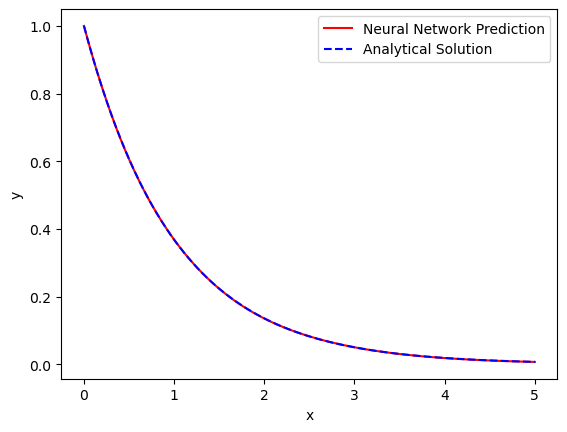

In [6]:
def get_y_smart(x, net):
    return 1 + x * net(x)

net = Net()
train_net(net, x, get_dydx_auto, get_y_smart, get_y_smart, MSELoss)

plot_net(net, x, get_y_smart, analytical = analytical)

This is such a smart technique. It is easy to implement and, as can be seen, proviedes the correct solution 


### Exercise 4:
Solve the differential equation
$$
\frac{dy}{dx} = -y\,(x-1);\; y(0) = 1
$$
Run the code twice to see whether the results are the same. The results for two successive runs may not be the same. Explain why this is the case.

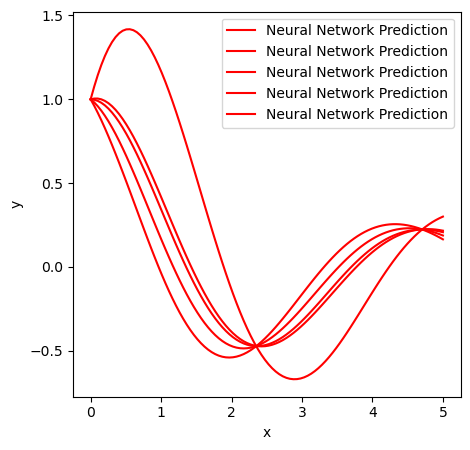

In [79]:
def get_y_rhs(x, net):
    return net(x-1)

def get_y_lhs(x, net):
    return net(x)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in range(5):
    net = Net()

    MSELoss_w_bound = lambda x, y: MSELoss(x, y) + torch.square(net(torch.tensor([0.])) - torch.tensor( [1.]))/10.

    train_net(net, x, get_dydx, get_y_lhs, get_y_rhs, MSELoss_w_bound)
    plot_net(net, x, get_y_lhs, ax=ax)

plt.show()

As can be seen above, the we have run the algorithm multiple times, and we do in fact get multiple different convergenced solutions. 

We suspect these solutions to come from the fact that our boundary condition is only for a single point, but as we have a "delayed" differential equation we might need to define a boundary condition that extends further in _x_, as mentioned in class.

We believe the different solution to be dependent on the random initializations of the network.